**Course**: [_Systèmes dynamiques en biologie_](https://moodle.epfl.ch/course/info.php?id=14291) (BIO-341)

**Professor**: _Felix Naef_

SSV, BA5, 2022

In [1]:
#import important libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from scipy.integrate import odeint
import math as mt
from mpl_toolkits.mplot3d import Axes3D
from sympy import var, plot_implicit
from matplotlib.lines import Line2D
set_matplotlib_formats('png', 'pdf')
import random

# Circadian oscillators

## 1. Sample exam question: Coupled oscillators (Paper and pencil)

Les phases de deux oscillateurs avec fréquence propre $\omega_1$ et $\omega_2$ sont notées $\phi_1(t)$ et
$\phi_2(t)$. 

Celles-ci sont couplées selon le modèle suivant :

\begin{equation}
\frac{d\phi_1}{dt} = \omega_1 + K f(\phi_2 - \phi_1)
\end{equation}
\begin{equation}
\frac{d\phi_2}{dt} = \omega_2  + K f(\phi_1 - \phi_2)
\end{equation}


avec $f(x) = sin(2x)$ 

Déterminez si les deux phases se synchronisent, c’est-à-dire que la différence de phase $\alpha =\phi_2-\phi_1$
atteint un point fixe stable

1. Posez l’équation différentielle pour la différence de phase $\alpha =\phi_2-\phi_1$. (1 point)

>\begin{equation}
\frac{d\alpha}{dt} = \frac{d\phi_2}{dt} -\frac{d\phi_1}{dt} = \omega_2 - \omega_1 - 2K sin(2\alpha)
\end{equation}

2. Expliquez si ce modèle permet la synchronisation des deux phases, et si oui, sous
quelles conditions. (2 points)
*Conseil : argumentez graphiquement ou par le calcul*

> Synchronisation: PF stable
> - Condition to have a PF :
>\begin{equation}
\omega_2 - \omega_1 - 2K sin(2\alpha^*) = 0 
\end{equation}

>\begin{equation}
sin(2\alpha^*) = \frac{\omega_2 - \omega_1}{2K}
\end{equation}

> For this equation to have a solution: $-1 \leq \frac{\omega_2 - \omega_1}{2K} \leq 1$, so
$- 2K \leq \omega_2 - \omega_1 \leq 2K$. 

>For $| \frac{\omega_2 - \omega_1}{2K}| = 1$ the model has 2 fixed points. For $-1 < \frac{\omega_2 - \omega_1}{2K} < 1$, the model has 4 fixed points. 

>Condition to have a stable PF: $F'(x)=-4Kcos(2\alpha^*)<0$, so $cos(2\alpha^*) > 0$. If the model has 4 fixed point, the condition is always respected for 2 out of 4 fixed points, so **the only condition for synchronisation is that $- 2K< \omega_2 - \omega_1 < 2K$**, strictly. In fact, when the model has 2 fixed points, the fixed points are semi-stable, so there is no synchronisation.

3. Que se passe-t-il pour a lorsque K tend vers l’infini ? (2 points)

> When K tends to infinity, $sin(2\alpha)$ tends to 0, and so does $\alpha$, the difference between the phases. So when K tends to infinity, the oscillators are synchronised and have the same phase.

## 2. Circadian oscillators and entrainement of a generic non-linear oscillator (Python)

Here, we first simulate a toy model of the circadian clock consisting of three variables that implements the now famous negative feedback loop oscillator (See the 2017 Nobel price in Physiology and Medicine).

## A three-variable  model of a circadian oscillator

This is a highly simplified model of a circadian oscillator (see Feedback of the Drosophila period gene product on circadian cycling of its messenger RNA levels, Hardin P, Hall JC and Rosbash M, Nature 1990). It takes into account some basic ingredients, notably the negative feedback loop. A clock gene mRNA (X) produces a clock protein (Y) which, in turn, activates a transcriptional inhibitor (Z).

\begin{equation}
\frac{dX}{dt} = v_{1} \frac{K_{1}^{4}}{K_{1}^{4} + Z^ {4}} - v_{2} \frac{X}{K_{2} + X} 
\end{equation}
\begin{equation}
\frac{dY}{dt} = k_{3}X  - v_{4} \frac{Y}{K_{4} + Y} 
\end{equation}
\begin{equation}
\frac{dZ}{dt} = k_{5}Y  - v_{6} \frac{Z}{K_{6} + Z}  
\end{equation}

### The Model

1) Explain the different variables, terms in the equations, and parameters. In particular explain the term containing the fractions.

> 1) 
>- In the first equation ($\frac{dX}{dt}$) we find the production of mRNA (transcription) which is regulated by 4 binding sites and the degradation of X (a first order enzymatic reaction), with $\textbf{v}$ being the relative rate
>- In the second equation ($\frac{dY}{dt}$) the translation (production of protein Y) is linearly dependent on X, and again a degradation term is present 
>- In the third equation ($\frac{dZ}{dt}$) the activation of Z is linearly dependent on the interaction with Y, and a degradation term is present.
X,Y and Z saturate for large values.

2) Based on the literature, discuss plausible genes/proteins that could represent the $X,Y,Z$ variables.

> 2) In Drosophila Melanogaster: X = $\textit{Per}$ mRNA, Y = PER protein, and Z = TIM protein, dimerize with PER, and repress the transcription of PER.

3) Discuss/criticize the main assumptions of the model.

> 3) One of the main assumption of the model is the linear nature of
- the relationship between the production of Y and the mRNA
- the relationship between the activation of Z and the Y 

In general, these process are not biologically regulated by linear processes (usually $\textit{sigmoids}$ better represent them). We can still assume though that under certain conditions the process is linear.


### Simulation of the Model

4) Using the values $v_{1} = 0.7 \,nMh^{-1}, v_{2} = v_{4} = v_{6} = 0.35\, nMh^{-1}, K_{1}=K_{2}=K_{4}=K_{6} = 1\,nM$ and $k_{3}=k_{5}=0.7\,h^{-1}$, simulate the model:  set appropriate initial conditions and time integration parameters to obtain a limit cycle. Plot some representative trajectories in 2D (x VS time, y VS time or z VS time) or 3D. 

In [28]:
#Definition of the model 

def model(s, t):
    # Parameters
    v1=0.7
    v2=v4=v6=0.35
    k3=k5=0.7
    # Variables
    x,y,z=s
    # Equations
    x_dot=v1*(1/(1+z**4))-v2*(x/(1+x))
    y_dot=k3*x-v4*(y/(1+y))
    z_dot=k5*y-v6*(z/(1+z))
    return x_dot, y_dot, z_dot

In [29]:
#Solving the differential equations

Tmax=5000
dt=0.01
tspan = np.arange(0, Tmax+dt, dt)

# Initial conditions setting 
X0=[0.14,0.18,1.8]

# Please note that the solution is containing both x,y and z. 
sol=odeint(model, X0, tspan)


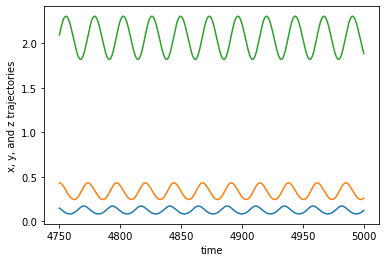

In [30]:
# 2D Plot of the trajectories (X,Y or Z vs T)

# This is used in order to take only a certain portion of the signal: indeed a limit cycle is an asymptotic behavior!
samp_frac= 0.05


plt.figure()

# We plot the trajectories for x,y and z, so we iterate over these 3
for i in range(sol.shape[1]): 
    plt.plot(tspan[-int(Tmax/dt*samp_frac):], sol[-int(Tmax/dt*samp_frac):,i])

plt.xlabel("time")
plt.ylabel("x, y, and z trajectories")
plt.show()

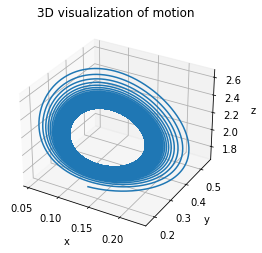

In [31]:
# 3D plot 
ax = plt.axes(projection='3d')
ax.plot(*sol.T)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_title("3D visualization of motion")
plt.show()
plt.close()

5) Use Period_finder on a long (many periods) trajectory on x. 
Comment the period distribution you find and its point estimate.
What happens if you use the y or z trajectory to evaluate the period?

The Period_finder function takes as an imput the x (or y or z) vector of coordinates and a vector of equally spaced times at wich the given coordinate was obtained with a simulation. 
It takes the x limits of the plot as a possible input, with default values of 0 to 50.
It returns a plot of the period distribution and a point estimate for the period.
If you want to understand how this function was built, read "A. few words on the discrete Fourier transform".

In [32]:
def Period_finder(x, tspan, xlim=[0,50]):
    
    fig,ax= plt.subplots()
    
    signal = x
    
    omega = np.fft.fft(signal)
    
    modes = np.arange(omega.size)
    
    t_dist = (tspan[-1]-tspan[0])
    
    omega_cut = len(omega)//2
    
    modes = modes[1:omega_cut]
    omega = omega[1:omega_cut]
    
    periods = t_dist/modes
    
    abs_o = np.absolute(omega)
    max_o = np.argmax(abs_o)
    
    period_estimate = periods[max_o]
    print("max = ", period_estimate)
    
    #period_mean = np.average(periods[max_o-5:max_o+5], weights=abs_o[max_o-5:max_o+5])#np.mean(periods[max_o-5:max_o+5])
    ax.axvline(period_estimate, ls='--', c='k')
    
    ax.plot(periods,abs_o/np.sum(abs_o))
    
    ax.set_xlim(xlim)
    ax.set_xlabel("period")
    ax.set_ylabel("propobabilty density")
    
    print("the expected period value is about " + str(round(period_estimate,2)) +" hours")
    
    return period_estimate


max =  23.80928571428571
the expected period value is about 23.81 hours


23.80928571428571

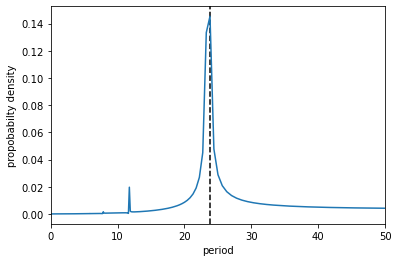

In [34]:
samp_frac=0.2
Period_finder(sol[-int(Tmax/dt*samp_frac):,0],tspan[-int(Tmax/dt*samp_frac):])

>5) If we only consider the peak we find a period of 23.81 hours, which is a reasonable value for a circadian oscillator.

#### Hopf bifurcation.
6) Vary the value of the transcription rate $v_{1}$ in the interval $(0,5]$ $nMh^{-1}$. You can plot some representative trajectories (see the code before and replace the v1). Plot and discuss the bifurcation diagram (show $X_{min}$ and $X_{max}$ in function of $v_{1}\in\left(0,5\right]$).

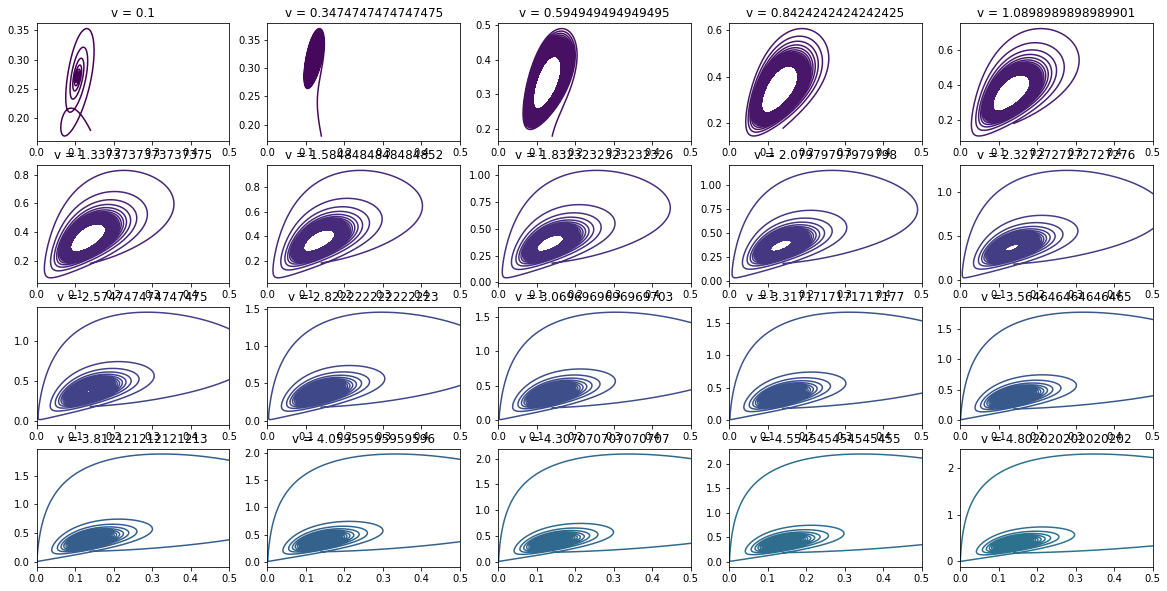

In [40]:
import matplotlib
sample_frac=0.05
# We define the model
def model(s, t):
    # Parameters
    v1=v
    v2=v4=v6=0.35
    k3=k5=0.7
    # Variable
    x,y,z=s
    # Model
    x_dot=v1*(1/(1+z**4))-v2*(x/(1+x))
    y_dot=k3*x-v4*(y/(1+y))
    z_dot=k5*y-v6*(z/(1+z))
    return x_dot, y_dot, z_dot

f, axs = plt.subplots(4,5, figsize=(20,10))
axs=axs.flatten()
cmap = matplotlib.cm.viridis

# We define a range in which we vary v
vspan=np.linspace(0.1,5,100)

X_lims=[]
for n,v in enumerate(vspan):
    # Initial Conditions
    X0=[0.14,0.18,1.8]
    # Solutions
    sol=odeint(model, X0, tspan)
    # X-Solution
    sol_x=sol[-int(Tmax/dt*samp_frac):,0]
    # We append the max and the min of the solution according to every different value of v
    X_lims.append([v, np.max(sol_x),np.min(sol_x)])
    
    if n%5==0:
        axs[n//5].plot(sol[:,0],sol[:,1],c=cmap.colors[n])
        axs[n//5].set_title("v = "+str(v))
        axs[n//5].set_xlim(0,0.8)
        axs[n//5].set_xlim(0,0.5)
        
    
X_lims=np.array(X_lims)

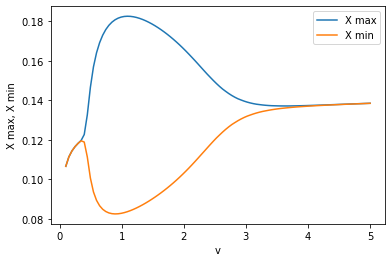

In [41]:
# We plot the minimum and the maximum of the solution according to v
plt.plot(X_lims[:,0], X_lims[:,1], label='X max')
plt.plot(X_lims[:,0], X_lims[:,2], label='X min')
plt.legend()
plt.xlabel("v")
plt.ylabel("X max, X min")
plt.show()

> 6) As we vary v, we see that there is a change in the nature of the fixed point. For low and high values of v, there is NO limit cycle (maximum and minimum of x coincide). In the middle range instead, the maximum of the function is different from the minimum, meaning that a limit cycle is present. 